In [1]:
import re
import random
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.models import load_model
from keras.layers import Embedding

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
data_path = "human_text.txt"
data_path2 = "robot_text.txt"
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().split('\n')
lines = [re.sub(r"\[\w+\]",'hi',line) for line in lines]
lines = [" ".join(re.findall(r"\w+",line)) for line in lines]
lines2 = [re.sub(r"\[\w+\]",'',line) for line in lines2]
lines2 = [" ".join(re.findall(r"\w+",line)) for line in lines2]
# Grouping lines by response pair
pairs = list(zip(lines,lines2))
random.shuffle(pairs)

In [4]:
print(len(pairs))

2363


In [5]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()
for line in pairs[:400]:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())


max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep] =  input_features_dict[token]
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep] =  target_features_dict[token]
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [6]:
print(pairs[:5])
print(input_docs[:5])

[('bad', 'ow why is that if you what to share'), ('muammo bor juda ko p sen yaralgansan nima maqsadda', 'o yin kulgi uchun'), ('õqimoq õzlashtirmoq dostim dany senga bir iltimosim bor', 'o rganish uchun eng yaxshi yo l gaplashayotgan'), ('oh i thought the numbers were much higher how do you estimate your progress in understanding human beings', 'i started chatting just a few days ago every day i learn something new but there is always more things to be learn'), ('do you brother or sister', 'i m gender neutral i m not boy or girl')]
['bad', 'muammo bor juda ko p sen yaralgansan nima maqsadda', 'õqimoq õzlashtirmoq dostim dany senga bir iltimosim bor', 'oh i thought the numbers were much higher how do you estimate your progress in understanding human beings', 'do you brother or sister']


In [7]:
embeddings_dictionary = dict()

glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [8]:
#encoder embedding matrix
EMBEDDING_SIZE = 100
embedding_matrix = zeros((num_encoder_tokens, EMBEDDING_SIZE))
for word, index in input_features_dict.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [9]:
#decoder embedding matrix
embedding_matrix2 = zeros((num_decoder_tokens, EMBEDDING_SIZE))
for word, index in target_features_dict.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix2[index] = embedding_vector


In [10]:
encoder_embedding_layer = Embedding(num_encoder_tokens, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_encoder_seq_length)
decoder_embedding_layer = Embedding(num_decoder_tokens, EMBEDDING_SIZE, weights=[embedding_matrix2], input_length=max_decoder_seq_length)

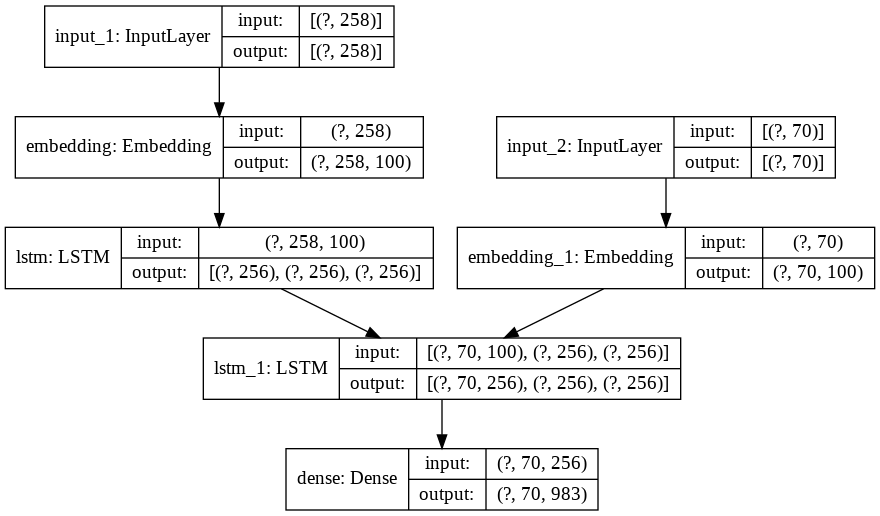

In [11]:
#Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 10
epochs = 600
#Encoder
encoder_inputs = Input(shape=(max_encoder_seq_length,))
x = encoder_embedding_layer(encoder_inputs)
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(x)
encoder_states = [state_hidden, state_cell]
#Decoder
decoder_inputs = Input(shape=(max_decoder_seq_length,))
x2 = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(x2, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#plot model
plot_model(training_model, to_file='embedding_model_plot.png', show_shapes=True, show_layer_names=True)


In [12]:
training_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 258)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 258, 100)     111700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 100)      98300       input_2[0][0]                    
_______________________________________________________________________________________

In [13]:
#Compiling
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Training
training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('embedding_model.h5')

Epoch 1/600
32/32 [==============================] - 2s 55ms/step - loss: 0.7714 - accuracy: 0.0154 - val_loss: 0.6024 - val_accuracy: 0.0145
Epoch 2/600
32/32 [==============================] - 1s 30ms/step - loss: 0.7103 - accuracy: 0.0170 - val_loss: 0.6103 - val_accuracy: 0.0161
Epoch 3/600
32/32 [==============================] - 1s 30ms/step - loss: 0.6842 - accuracy: 0.0190 - val_loss: 0.6142 - val_accuracy: 0.0162
Epoch 4/600
32/32 [==============================] - 1s 30ms/step - loss: 0.6587 - accuracy: 0.0199 - val_loss: 0.6157 - val_accuracy: 0.0175
Epoch 5/600
32/32 [==============================] - 1s 30ms/step - loss: 0.6346 - accuracy: 0.0216 - val_loss: 0.6192 - val_accuracy: 0.0193
Epoch 6/600
32/32 [==============================] - 1s 30ms/step - loss: 0.6127 - accuracy: 0.0235 - val_loss: 0.6271 - val_accuracy: 0.0198
Epoch 7/600
32/32 [==============================] - 1s 30ms/step - loss: 0.5922 - accuracy: 0.0243 - val_loss: 0.6318 - val_accuracy: 0.0198
Epoch 

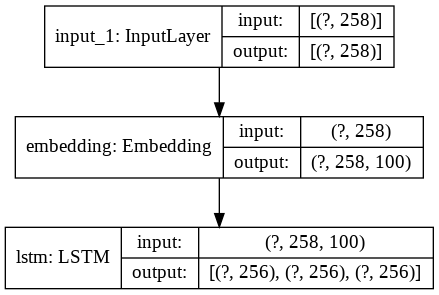

In [14]:
#testing model
training_model = load_model('embedding_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[4].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='embedding_model_plot4a.png', show_shapes=True, show_layer_names=True)

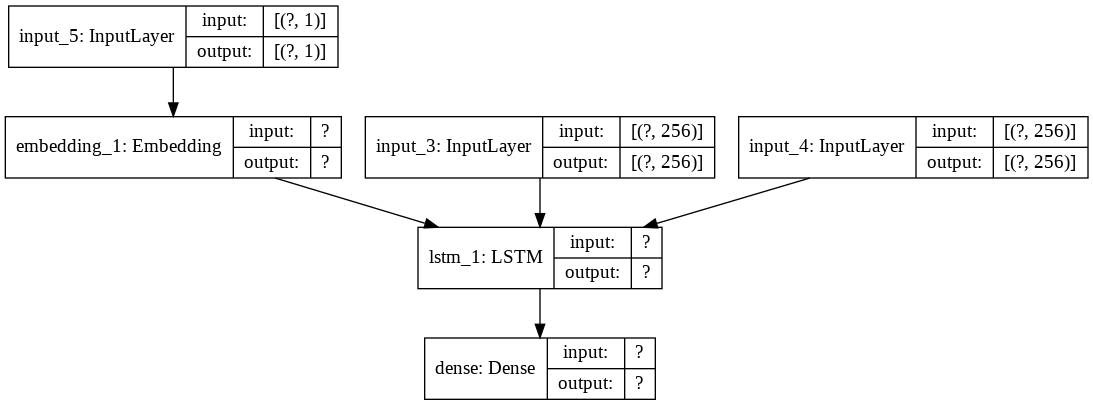

In [15]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)


decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)
plot_model(decoder_model, to_file='embedding_model_plot4b.png', show_shapes=True, show_layer_names=True)


In [16]:
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             98300       input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
_______________________________________________________________________________________

In [17]:
def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,))

    #Setting the first token of target sequence with the start token
    target_seq[0] = target_features_dict['<START>']
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
    #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
    #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
    #Update the target sequence
          target_seq = np.zeros((1,))
    #Setting the first token of target sequence with the start token
          target_seq[0] = sampled_token_index
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [18]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
#Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
#Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep] =  input_features_dict[token]
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()


In [19]:
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
hi
 i m fine too happy to have someone to talk with i m here to be your virtual
sounds good
 i m not understanding what are we talking about 
me either
 i m fine too happy to have someone to talk with i m here to be your virtual
you are funny
 i m fine too happy to have someone to talk with i m here to be your virtual
i am not fine now
 i m fine too happy to have someone to talk with i m here to be your virtual
exit
Ok, have a great day!
